In [ ]:
!pip install diffusers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 16.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 24.3 MB/s eta 0:00:00


In [ ]:
import torch
from torch import nn
import torchvision
import torchvision.transforms as T

import os
import random

import numpy as np

import diffusers
from diffusers import UNet2DModel

import matplotlib.pyplot as plt

In [ ]:
BATCH_SIZE = 64
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
SEED = 123
BATCH_SIZE, DEVICE, SEED

(64, device(type='cuda'), 123)

In [ ]:
def seed_everything(seed: int):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
seed_everything(SEED)

### dataset and dataloader

In [ ]:
# Padding is necesarry to make 28x28 images to 32x32 which can then be input into the diffuser's U-Net

transforms = T.Compose([T.ToTensor(),T.Pad(2)])

train_ds = torchvision.datasets.FashionMNIST(root = './data/train',train = True,download = True,transform = transforms)
valid_ds = torchvision.datasets.FashionMNIST(root = './data/valid',train = False,download = True,transform = transforms)

100%|██████████| 26421880/26421880 [00:01<00:00, 17719176.02it/s]


Extracting ./data/train/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/train/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 295368.59it/s]


Extracting ./data/train/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/train/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 5587549.09it/s]


Extracting ./data/train/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/train/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 6179815.97it/s]


Extracting ./data/train/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/train/FashionMNIST/raw



100%|██████████| 26421880/26421880 [00:01<00:00, 17451028.76it/s]


Extracting ./data/valid/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/valid/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 297675.44it/s]


Extracting ./data/valid/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/valid/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 5511055.78it/s]


Extracting ./data/valid/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/valid/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 6367524.92it/s]

Extracting ./data/valid/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/valid/FashionMNIST/raw



In [ ]:
train_dl = torch.utils.data.DataLoader(dataset = train_ds,
                                               batch_size = BATCH_SIZE,
                                               shuffle = True,
                                                num_workers = 2,
                                                prefetch_factor=2,
                                                drop_last = True,
                                                pin_memory=True)
valid_dl = torch.utils.data.DataLoader(dataset = valid_ds,
                                               batch_size = BATCH_SIZE,
                                               shuffle = False,
                                                num_workers = 2,
                                                prefetch_factor=2,
                                               drop_last = False)

In [ ]:
x, y = next(iter(train_dl))
x = x.to(DEVICE)
x.device, x.shape, y.shape

(device(type='cuda', index=0), torch.Size([64, 1, 32, 32]), torch.Size([64]))

### utilities

In [ ]:
def plot_images(batch, idxToDsiplay=None, display=(1, 8)):
    batch = batch.detach().cpu()
    fig = plt.figure()
    rng = np.random.default_rng()
    if idxToDsiplay is None:
        idxToDsiplay = rng.choice(batch.shape[0], size=min(batch.shape[0], display[0]*display[1]), replace=batch.shape[0]<(display[0]*display[1]))
    for i, idx in enumerate(idxToDsiplay):
        ax = fig.add_subplot(display[0], display[1], i+1)
        ax.imshow(batch[idx].permute(1, 2, 0), cmap='gray')
        ax.xaxis.set_ticklabels([])
        ax.yaxis.set_ticklabels([])
    plt.subplots_adjust(wspace=0.08, hspace=-0.65)
    plt.show()
    return idxToDsiplay

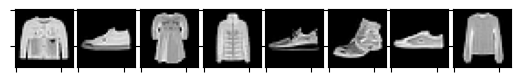

[30  3 29 36 20 15 27  1]


In [ ]:
i = plot_images(x)
print(i)

### model

In [ ]:
# Define in-channels and out-channels as we have grayscale images and also change the out channels as we don't need a model as large as the default configuration
unet_model = UNet2DModel(in_channels=1, out_channels=1, block_out_channels=(32, 64, 128, 128),norm_num_groups=8)

In [ ]:
class myUnet(nn.Module):
	# Initialize with diffuser's U-Net
    def __init__(self, model):
        super().__init__()
        self.model = model

	# Must use this method to get outputs from U-Net
	# The model takes in a tuple of size 2
	# i.e input should be of the form (x_t,t) where x_t is a batch of images and t is a 1D vector
    def forward(self, x):
        return self.model.forward(*x).sample

# You can now just call the following model as you normally do
model = myUnet(unet_model).to(DEVICE)

minimum value = -2.068533182144165, maximum value = 0.9292620420455933


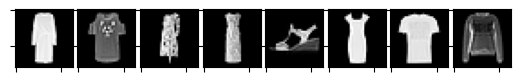

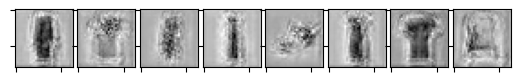

In [ ]:
input = (x, torch.randint(low=0, high=100, size=(x.shape[0],)).to(DEVICE))
output = model(input)
print(f"minimum value = {torch.min(output)}, maximum value = {torch.max(output)}")
i = plot_images(x)
plot_images(output.detach(), idxToDsiplay=i);

### noise scheduler

In [ ]:
class DiffusionScheduler():
    def __init__(self, diffusionScheduler, device="cpu", nc=1, img_width=32, img_height=32):
        self.diffusion_scheduler = diffusionScheduler
        self.device = device
        self.nc = nc
        self.img_width = img_width
        self.img_height = img_height

    def sample_timesteps(self, n):
        return torch.randint(low=1, high=self.diffusion_scheduler.config.num_train_timesteps, size=(n,), device=self.device).long()

    def noise_images(self, x, t):
        noise = torch.randn_like(x, device=self.device)
        # print(x.device, noise.device, t.device)
        noisy_images = self.diffusion_scheduler.add_noise(x, noise, t)
        return noisy_images, noise

    def sample(self, model, n):
        model.eval()
        input = torch.randn((n, self.nc, self.img_width, self.img_height)).to(self.device)
        for t_ in self.diffusion_scheduler.timesteps:
            with torch.no_grad():
                noisy_residual = model((input, t_))
            previous_noisy_sample = self.diffusion_scheduler.step(noisy_residual, t_, input).prev_sample
            input = previous_noisy_sample
        return input

In [ ]:
class LinearNoiseScheduler():
    def __init__(self, noise_steps=500, beta_start=1e-4, beta_end=0.02, img_size=32, device="cpu"):
        self.noise_steps = noise_steps
        self.beta_start = beta_start
        self.beta_end = beta_end
        self.img_size = img_size
        self.device = device

        self.beta = torch.linspace(self.beta_start, self.beta_end, self.noise_steps).to(self.device)
        self.alpha = 1. - self.beta
        self.alpha_hat = torch.cumprod(self.alpha, dim=0)

    def sample_timesteps(self, n):
        return torch.randint(low=1, high=self.noise_steps, size=(n,)).to(self.device)

    def noise_images(self, x, t):
        sqrt_alpha_hat = torch.sqrt(self.alpha_hat[t])[:, None, None, None]
        sqrt_one_minus_alpha_hat = torch.sqrt(1 - self.alpha_hat[t])[:, None, None, None]
        Ɛ = torch.randn_like(x)
        return sqrt_alpha_hat * x + sqrt_one_minus_alpha_hat * Ɛ, Ɛ

    def denoise_images(self, x_t, pred_noise, t):
        sqrt_alpha_hat = torch.sqrt(self.alpha_hat[t])[:, None, None, None]
        sqrt_one_minus_alpha_hat = torch.sqrt(1 - self.alpha_hat[t])[:, None, None, None]
        return (x_t - sqrt_one_minus_alpha_hat*pred_noise) / sqrt_alpha_hat

    @torch.no_grad()
    def sample(self, model, n):
        model.eval()
        with torch.no_grad():
            x = torch.randn((n, 1, self.img_size, self.img_size)).to(self.device)
            for i in reversed(range(1, self.noise_steps)):
                t = (torch.ones(n) * i).long().to(self.device)
                predicted_noise = model((x, t))
                alpha = self.alpha[t][:, None, None, None]
                alpha_hat = self.alpha_hat[t][:, None, None, None]
                beta = self.beta[t][:, None, None, None]
                if i > 1:
                    noise = torch.randn_like(x)
                else:
                    noise = torch.zeros_like(x)
                x = 1 / torch.sqrt(alpha) * (x - ((1 - alpha) / (torch.sqrt(1 - alpha_hat))) * predicted_noise) + torch.sqrt(beta) * noise
        x = (x.clamp(-1, 1) + 1) / 2
        # x = (x * 255).type(torch.uint8)
        return x

In [ ]:
ns = diffusers.DDIMScheduler()
ns.set_timesteps(50)
noise_scheduler = DiffusionScheduler(ns, device=DEVICE)
# noise_scheduler = LinearNoiseScheduler(device='cpu')

In [ ]:
t = noise_scheduler.sample_timesteps(x.shape[0])
x_t, noise = noise_scheduler.noise_images(x, t)
mse = torch.nn.MSELoss()
predicted_noise = model((x_t, t))
predicted_noise.shape, mse(noise, predicted_noise)

(torch.Size([64, 1, 32, 32]),
 tensor(1.3724, device='cuda:0', grad_fn=<MseLossBackward0>))

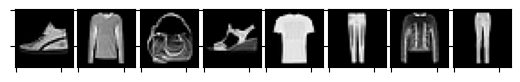

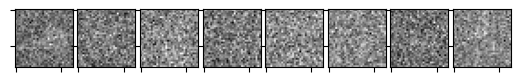

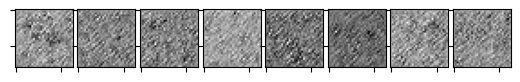

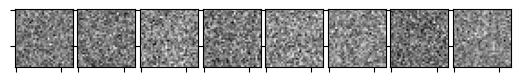

array([ 5, 17, 12, 39, 44,  4, 56, 23])

In [ ]:
i = plot_images(x)
plot_images(x_t, i)
plot_images(predicted_noise.detach(), i)
plot_images(noise, i)

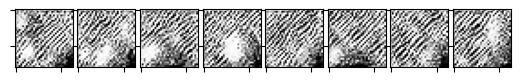

array([6, 3, 1, 7, 4, 0, 2, 5])

In [ ]:
sampled_images = noise_scheduler.sample(model, 8)
plot_images(sampled_images)

In [ ]:
type(sampled_images), sampled_images.shape, torch.min(sampled_images), torch.max(sampled_images)

(torch.Tensor,
 torch.Size([8, 1, 32, 32]),
 tensor(-1., device='cuda:0'),
 tensor(1., device='cuda:0'))

###Training

In [ ]:
import time
import tqdm.notebook as tqdm

#### defining Task class

In [ ]:
class Task():
    '''This class helps in efficiently training pytorch model easily'''
    def __init__(self, model,
                 BASE_PATH,
                 train_dataloader,
                 val_dataloader=None,
                 noise_scheduler = None,
                 DEVICE='cpu',
                 lr=0.001):
        self.model = model
        self.BASE_PATH = BASE_PATH #path where the output from training will be saved
        self.train_dataloader = train_dataloader
        self.val_dataloader = val_dataloader
        self.DEVICE = DEVICE #device type 'cuda' or 'cpu'
        self.lr = lr   # model learning rate
        self.optimizer = self.get_optimizer()
        self.scheduler = self.get_scheduler()
        self.noise_scheduler = noise_scheduler
        self.version_dir = None
        self.history = {} # dictionary that stores loss and other metrices each epoch

    def get_scheduler(self):
        '''reurn a scheduler'''
        return torch.optim.lr_scheduler.ReduceLROnPlateau(self.optimizer, mode='min',
                                                   factor=0.8, patience=3,
                                                   threshold=0.0001, threshold_mode='rel',
                                                   cooldown=2, min_lr=0.000001,
                                                   eps=1e-08, verbose=False)

    def get_loss(self, noise_added, noise_predicted):
        '''write the loss function here'''
        return torch.nn.functional.mse_loss(noise_predicted, noise_added)
        # print(torch.min(noise_added), torch.max(noise_added), torch.min(noise_predicted), torch.max(noise_predicted))
        # print(mse(noise_added, noise_predicted))
        # l = mse(noise_added, noise_predicted)
        # print(l.item(), end=" ")
        # return torch.nn.functional.cross_entropy(noise_predicted, noise_added)
        # return mse(noise_predicted, noise_added)

    def plot_images(self, X):
        '''this fuunction is called for plotting images in between trainng'''
        idxToPlot = plot_images(X.detach().cpu())

    def get_optimizer(self):
        '''return optimizer'''
        return torch.optim.Adam(self.model.parameters(), self.lr, weight_decay=1e-5)

    def get_version_dir(self):
        '''this function return the new folder name for saving the output of current training run'''
        versions = sorted([int(f.name[7:]) for f in os.scandir(self.BASE_PATH) if f.is_dir() and f.name.startswith('Version')])
        curr_version = None
        if len(versions)==0:
            curr_version = 'Version0'
        else:
            curr_version = f'Version{versions[-1]+1}'
        PATH = os.path.join(self.BASE_PATH, curr_version)
        if not os.path.exists(PATH):
           os.makedirs(PATH)
        print(f"The output for current run will be saved at {PATH}")
        return PATH

    def save_checkpoint(self, name, epoch):
        '''this function saves the checkpoint with the given parameter "name"'''
        # save model and history
        PATH = os.path.join(self.version_dir, name)
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'history': self.history,
            }
        if self.scheduler:
            checkpoint['scheduler'] = self.scheduler.state_dict()
        torch.save(checkpoint, PATH)

    def load_checkpoint(self, PATH):
        '''this function load the checkpoint for given "PATH"'''
        checkpoint = torch.load(PATH)
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        self.history = checkpoint['history']
        if self.scheduler:
            self.scheduler.load_state_dict(checkpoint['scheduler'])
        return checkpoint['epoch']

    def train(self, max_epochs=25,
              continue_training=False, continue_path=None,
              validate_after_k=1, #validate after k epoch
              save_after_k=-1, #save after k epoch
              plot_after_k=1,
              clip_gradient=True): #plot imges after k epoch
        #get the directory to save output of current run
        self.version_dir = self.get_version_dir()

        #set the model to device
        self.model = self.model.to(self.DEVICE)

        best_loss = float('inf') #tracking validation loss for each epoch
        update_best = True

        start_epoch = 0
        # load trained model
        if continue_training:
            start_epoch = self.load_checkpoint(continue_path)

        for epoch in tqdm.trange(start_epoch, max_epochs):
            since = time.time()
            running_metrics = {}
            running_metrics.setdefault('train_loss', 0.0)
            running_metrics.setdefault('val_loss', 0.0)

            #Training mode
            self.model.train()
            tqdm_loader = tqdm.tqdm(self.train_dataloader)
            for batch in tqdm_loader:
                tqdm_loader.set_description(f"Training Epoch {epoch}")
                self.optimizer.zero_grad() # zero the parameter gradients
                X = batch[0].to(self.DEVICE)
                t = self.noise_scheduler.sample_timesteps(X.shape[0])
                X_t, noise_added = self.noise_scheduler.noise_images(X, t)
                # track history if only in train
                with torch.set_grad_enabled(True):
                    self.optimizer.zero_grad() # zero the parameter gradients
                    pred_noise = self.model((X_t, t))
                    loss = self.get_loss(noise_added, pred_noise)
                    loss.backward()
                    if clip_gradient:
                        torch.nn.utils.clip_grad_value_(model.parameters(), clip_value=1.0)
                    self.optimizer.step()
                # statistics
                running_metrics['train_loss'] += loss.item()
                tqdm_loader.set_postfix(training_loss=loss.item())

            #Validation mode
            validation_done = False
            if (self.val_dataloader != None) and ((epoch-start_epoch+1)%validate_after_k ==0):
                model.eval()
                tqdm_loader = tqdm.tqdm(self.val_dataloader)
                for batch in tqdm_loader:
                    tqdm_loader.set_description(f"Validating Epoch {epoch}")
                    X = batch[0].to(self.DEVICE)
                    t = self.noise_scheduler.sample_timesteps(X.shape[0])
                    X_t, noise_added = self.noise_scheduler.noise_images(X, t)
                    # predict
                    pred_noise = self.model((X_t, t))
                    loss = self.get_loss(noise_added, pred_noise)
                    # statistics
                    running_metrics['val_loss'] += loss.item()
                    tqdm_loader.set_postfix(validation_loss=loss.item())
                # LR scheduler
                if self.scheduler is not None:
                    self.scheduler.step(running_metrics['val_loss'])
                print(f"total validation loss = {running_metrics['val_loss']}")
                validation_done = True

                #define how to get the best and set (update_best=True/False) based on that
                if running_metrics['val_loss'] < best_loss:
                    best_loss = running_metrics['val_loss']
                    update_best = True
                else:
                    update_best = False

            #plotting after k epochs
            if ((epoch-start_epoch+1)%plot_after_k ==0):
                sampled_images = self.noise_scheduler.sample(model, 8)
                self.plot_images(sampled_images)

            # saving epoch level matrices
            for metric_name in running_metrics:
                if metric_name.startswith('val') and validation_done:
                    self.history.setdefault('val', {}).setdefault(metric_name, []).append(running_metrics[metric_name])
                if metric_name.startswith('train'):
                    self.history.setdefault('train', {}).setdefault(metric_name, []).append(running_metrics[metric_name])

            #save model
            if update_best:
                print('updating best checkpoint')
                self.save_checkpoint('best', epoch)
            if save_after_k!=-1 and (epoch+1)%save_after_k==0:
                self.save_checkpoint(f'epoch{epoch}', epoch)
            if epoch == (max_epochs-1):
                self.save_checkpoint('last', epoch)

            time_elapsed = time.time() - since
            self.history.setdefault('times', []).append(time_elapsed)     # save times per-epoch
            print(f"Epoch {epoch} complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s with total training loss {self.history['train']['train_loss'][-1]}")

In [ ]:
# # Fit function to train the model

# def fit(model,train_dl,valid_dl,loss_func,epochs,opt,sched):
#     scaler = torch.cuda.amp.GradScaler()
#     for epoch in range(epochs):
#         losses = []
#         model.train()
#         for xb,_ in train_dl:
#             opt.zero_grad()
#             xb = to_device(xb)
#             (x_t, timesteps), noise = model.add_noise(xb)
#             (x_t, timesteps) = to_device((x_t, timesteps))
#             noise = to_device(noise)
#             with torch.cuda.amp.autocast(dtype=torch.float16):
#                 preds = model((x_t, timesteps))
#                 loss = loss_func(preds, noise)
#             losses.append(loss.item() * len(xb))
#             scaler.scale(loss).backward()
#             scaler.step(opt)
#             sched.step()
#             scaler.update()
#         print(f"Epoch {epoch} train loss: {sum(losses)/len(train_ds)}")
#         model.eval()
#         losses = []
#         with torch.no_grad():
#             for xb,_ in valid_dl:
#                 xb = to_device(xb)
#                 (x_t, timesteps), noise = add_noise(xb, model.alphabar)
#                 (x_t, timesteps) = to_device((x_t, timesteps))
#                 noise = to_device(noise)
#                 preds = model((x_t, timesteps))
#                 loss = loss_func(preds, noise)
#                 losses.append(loss.item() * len(xb))
#         print(f"Epoch {epoch} valid loss: {sum(losses)/len(valid_ds)}")

#### Training

In [ ]:
# torch.nn.functional.mse_loss
# opt = optim.Adam(model.parameters(), lr=lr,eps = 1e-5)
# sched = optim.lr_scheduler.OneCycleLR(opt, lr, epochs=epochs, steps_per_epoch=len(train_dl))

In [ ]:
# mse = torch.nn.functional.MSELoss()
# torch.optim.lr_scheduler.ReduceLROnPlateau(self.optimizer, mode='min',
#                                                    factor=0.8, patience=3,
#                                                    threshold=0.0001, threshold_mode='rel',
#                                                    cooldown=2, min_lr=0.000001,
#                                                    eps=1e-08, verbose=False)
# torch.optim.Adam(self.model.parameters(), self.lr, weight_decay=1e-5)

In [ ]:
ns = diffusers.DDIMScheduler()
ns.set_timesteps(40)
noise_scheduler = DiffusionScheduler(ns, device=DEVICE)

In [ ]:
BASE_PATH = '/content'
NUM_EPOCHS = 5
LR = 0.0001
unet_model = UNet2DModel(in_channels=1, out_channels=1, block_out_channels=(32, 64, 128, 128),norm_num_groups=8)
model = myUnet(unet_model)

In [ ]:
diffusion_model_trainng = Task(model = model,
                            BASE_PATH = BASE_PATH,
                            train_dataloader = train_dl,
                            val_dataloader = valid_dl,
                            noise_scheduler = noise_scheduler,
                            DEVICE=DEVICE,
                            lr=LR)

The output for current run will be saved at /content/Version2


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/937 [00:00<?, ?it/s]

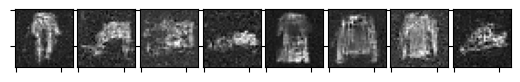

updating best checkpoint
Epoch 0 complete in 3m 3s with total training loss 49.56187569722533


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

total validation loss = 3.5941861318424344


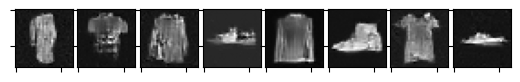

updating best checkpoint
Epoch 1 complete in 3m 14s with total training loss 23.29956405609846


  0%|          | 0/937 [00:00<?, ?it/s]

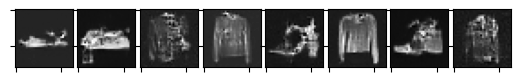

updating best checkpoint
Epoch 2 complete in 3m 4s with total training loss 21.029385312460363


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

total validation loss = 3.186365413479507


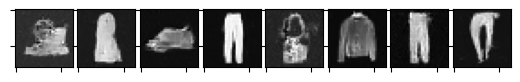

updating best checkpoint
Epoch 3 complete in 3m 15s with total training loss 19.258872978389263


  0%|          | 0/937 [00:00<?, ?it/s]

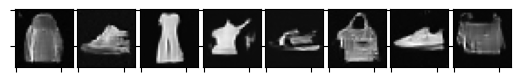

updating best checkpoint
Epoch 4 complete in 3m 5s with total training loss 18.740169075783342


In [ ]:
diffusion_model_trainng.train(max_epochs=NUM_EPOCHS,
                            continue_training=False,
                            continue_path=None,
                            validate_after_k=2,
                            save_after_k=-1,
                            plot_after_k=1)

In [ ]:
# import shutil
# shutil.rmtree('/content/Version0')

In [ ]:
test_model = myUnet(unet_model)
PATH = '/content/Version2/best'
checkpoint = torch.load(PATH)

test_model.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
history = checkpoint['history']
# if self.scheduler:
    # self.scheduler.load_state_dict(checkpoint['scheduler'])

In [ ]:
ns = diffusers.DDIMScheduler()
ns.set_timesteps(50)
noise_scheduler = DiffusionScheduler(ns, device=DEVICE)

In [ ]:
history

{'train': {'train_loss': [49.56187569722533,
   23.29956405609846,
   21.029385312460363,
   19.258872978389263,
   18.740169075783342]},
 'times': [183.0818703174591,
  194.04184937477112,
  184.2027463912964,
  195.17988562583923],
 'val': {'val_loss': [3.5941861318424344, 3.186365413479507]}}

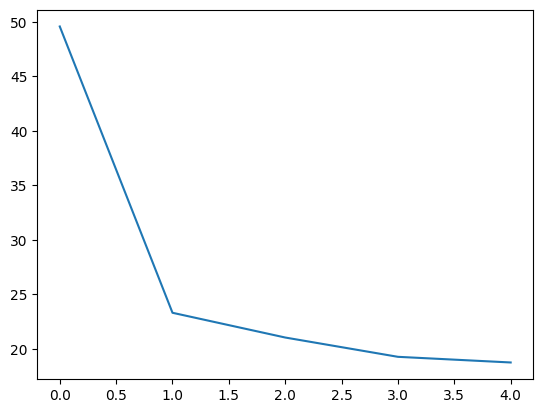

In [ ]:
plt.plot(history['train']['train_loss'])

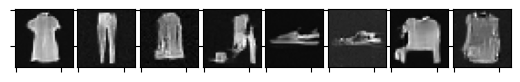

In [ ]:
sampled_images = noise_scheduler.sample(test_model, 8)
idxToPlot = plot_images(sampled_images.detach().cpu())